In [1]:
import pandas as pd

data = pd.read_csv("data/ohe_customer_dataset.csv", sep=",")

In [2]:
from funpymodeling import status

status(data)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,transactionFailed,0,0.0,455,0.731511,2,bool
1,"orderAmount_(9.999, 18.2]",0,0.0,526,0.845659,2,int64
2,"orderAmount_(18.2, 30.4]",0,0.0,527,0.847267,2,int64
3,"orderAmount_(30.4, 39.0]",0,0.0,524,0.842444,2,int64
4,"orderAmount_(39.0, 47.0]",0,0.0,525,0.844051,2,int64
...,...,...,...,...,...,...,...
58,customerIPAddressSimplified_nan,0,0.0,622,1.000000,1,int64
59,sameCity_no,0,0.0,485,0.779743,2,int64
60,sameCity_unknown,0,0.0,139,0.223473,2,int64
61,sameCity_yes,0,0.0,620,0.996785,2,int64


In [3]:
customer_dataset_preparado_sin_ohe = pd.read_csv("data/customer_dataset_preparado_sin_ohe.csv", sep=",")

In [4]:
filter_data = data[["orderState_failed", 
                    "orderState_fulfilled", 
                    "orderState_pending", 
                    "transactionFailed", 
                    # "fraudulent", 
                    "customerIPAddressSimplified_digits_and_letters"]].copy()

filter_data_x = filter_data.copy()


In [5]:
filter_data['fraudulent'] = customer_dataset_preparado_sin_ohe['fraudulent']

filter_data_y = filter_data['fraudulent']

In [7]:
status(filter_data_x)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,orderState_failed,0,0.0,572,0.919614,2,int64
1,orderState_fulfilled,0,0.0,223,0.358521,2,int64
2,orderState_pending,0,0.0,594,0.954984,2,int64
3,transactionFailed,0,0.0,455,0.731511,2,bool
4,customerIPAddressSimplified_digits_and_letters,0,0.0,545,0.876206,2,int64


In [9]:
status(filter_data_y)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,fraudulent,0,0.0,107,0.172026,3,int64


In [10]:
# Normalizamos los datos para entrenar un Modelo KMEANS (parametros z-score)

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
std_scaler.fit(filter_data_x)
x_data_norm=std_scaler.transform(filter_data_x)

# A ver que hizo!?
pd.DataFrame(x_data_norm).describe()

,0,1,2,3,4
count,6.220000e+02,6.220000e+02,6.220000e+02,6.220000e+02,622.000000
mean,-2.855879e-17,9.138813e-17,-5.711758e-18,1.370822e-16,0.000000
std,1.000805e+00,1.000805e+00,1.000805e+00,1.000805e+00,1.000805
min,-2.956562e-01,-1.337624e+00,-2.171130e-01,-6.058325e-01,-0.375878
25%,-2.956562e-01,-1.337624e+00,-2.171130e-01,-6.058325e-01,-0.375878
50%,-2.956562e-01,7.475943e-01,-2.171130e-01,-6.058325e-01,-0.375878
75%,-2.956562e-01,7.475943e-01,-2.171130e-01,1.650621e+00,-0.375878
max,3.382307e+00,7.475943e-01,4.605897e+00,1.650621e+00,2.660436


In [11]:
from sklearn.cluster import KMeans

cl_model = KMeans(
    n_clusters=3,     # el parámetro importante!
    init='k-means++', # k-means++ acelera la convergencia, respecto de random
    max_iter=100, 
    random_state=0,
    n_init='auto'     # Para evitar warnings más adelante
)

cl_model.fit(x_data_norm)

KMeans(max_iter=100, n_clusters=3, n_init='auto', random_state=0)

In [ ]:
pred_cl = cl_model.predict(x_data_norm)

# Resultado número de cluster: 
pred_cl

In [13]:
cl_model

KMeans(max_iter=100, n_clusters=3, n_init='auto', random_state=0)

In [14]:
from copy import deepcopy

In [15]:
cluster_var='cluster' # definan nombre de var de clustering
x_data_cl=filter_data_x.copy() # hagan copia de los datos de TR para no perderlos
x_data_cl[cluster_var]=cl_model.predict(x_data_norm) # ojo aca! el predict es de los datos normalizados

In [16]:
x_data_cl.head()

,orderState_failed,orderState_fulfilled,orderState_pending,transactionFailed,customerIPAddressSimplified_digits_and_letters,cluster
0,0,0,1,False,0,0
1,0,1,0,False,0,1
2,0,1,0,False,1,1
3,0,1,0,False,1,1
4,0,1,0,True,0,1


In [17]:
from funpymodeling.model_validation import coord_plot

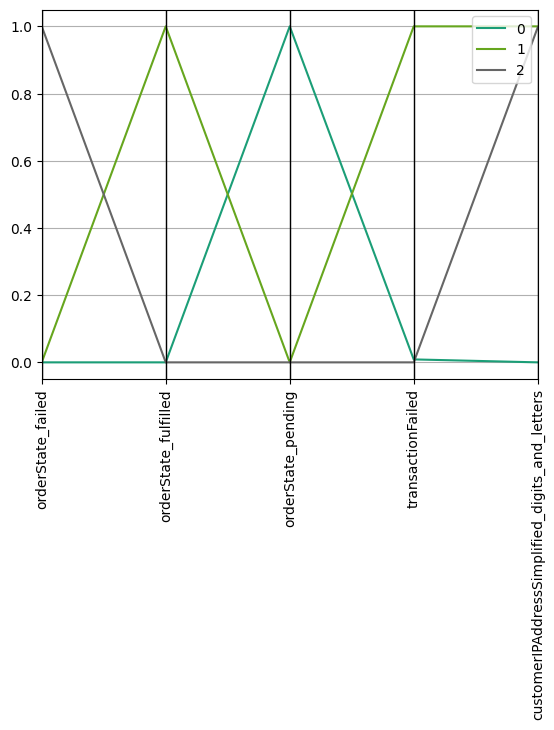

In [18]:
d_orig, d_transf = coord_plot(x_data_cl, cluster_var)

# FRAUDULENT referencia:  {'False': 0, 'True': 1, 'warning': 2}

INSIGHTS:

1) Cuando es fraudulenta, el IP ADDRESS del dispositivo es complejo, tiene número y letras, y han habido Failed Transactions.
2) Cuando NO es fraudulenta, sucede lo contrario al item anterior.
3) Cuando NO es fraudulenta, el Order State y la Transaction no fallan.

In [19]:
d_orig

,orderState_failed,orderState_fulfilled,orderState_pending,transactionFailed,customerIPAddressSimplified_digits_and_letters,cluster
0,0.0,0.0,0.16185,0.260116,0.028902,0
1,0.0,1.0,0.00000,0.273183,0.160401,1
2,1.0,0.0,0.00000,0.260000,0.160000,2


In [20]:
d_transf

,orderState_failed,orderState_fulfilled,orderState_pending,transactionFailed,customerIPAddressSimplified_digits_and_letters,cluster
0,0.0,0.0,1.0,0.008769,0.000000,0
1,0.0,1.0,0.0,1.000000,1.000000,1
2,1.0,0.0,0.0,0.000000,0.996951,2


In [21]:
# Scatter 3D

# Consideren x='orderState_failed', y='customerIPAddressSimplified_digits_and_letters', z='transactionFailed', color='fraudulent'

# Selección de variables

d2=filter_data[['orderState_failed', 'customerIPAddressSimplified_digits_and_letters','transactionFailed','fraudulent']]

# Usamos la maravilla de plotly
import plotly.express as px

fig = px.scatter_3d(d2, x='orderState_failed', y='customerIPAddressSimplified_digits_and_letters', z='transactionFailed', color='fraudulent')
fig.show()


In [23]:
import hdbscan

In [24]:
model_hdb = hdbscan.HDBSCAN()
model_hdb.fit(filter_data)

HDBSCAN()

In [ ]:
# Número de clusters:
model_hdb.labels_

In [27]:
from funpymodeling.exploratory import freq_tbl, todf

freq_tbl(model_hdb.labels_.astype('str'))

,0,frequency,percentage,cumulative_perc
0,5,196,0.315113,0.315113
1,10,105,0.16881,0.483923
2,3,66,0.106109,0.590032
3,4,40,0.064309,0.654341
4,14,30,0.048232,0.702572
5,12,27,0.043408,0.745981
6,8,24,0.038585,0.784566
7,-1,23,0.036977,0.821543
8,13,22,0.03537,0.856913
9,1,16,0.025723,0.882637


In [ ]:
# OBTUVIMOS 17 CLUSTERS (1 DE ELLOS ES DE AQUELLOS QUE NO SE ADAPTABAN A LOS OTROS CLUSTERS)

In [28]:
# Reentrenamos, pero cconfigurando el min_cluster_size = 15.
model_hdb2 = hdbscan.HDBSCAN(min_cluster_size=15).fit(filter_data)

In [29]:
freq_tbl(model_hdb2.labels_.astype('str'))

,0,frequency,percentage,cumulative_perc
0,6,196,0.315113,0.315113
1,8,105,0.16881,0.483923
2,-1,94,0.151125,0.635048
3,2,66,0.106109,0.741158
4,3,41,0.065916,0.807074
5,4,30,0.048232,0.855305
6,1,27,0.043408,0.898714
7,5,24,0.038585,0.937299
8,7,23,0.036977,0.974277
9,0,16,0.025723,1.0


In [ ]:
# Tenemos menos clusters, pero el cluster de ruido tiene más casos.

In [30]:
# Análisis del modelo cluster (profiling)

cluster_var = 'cluster'
x_data_cl = filter_data.copy()
x_data_cl[cluster_var] = model_hdb2.labels_

In [31]:
x_data_cl.head(5)

,orderState_failed,orderState_fulfilled,orderState_pending,transactionFailed,customerIPAddressSimplified_digits_and_letters,fraudulent,cluster
0,0,0,1,False,0,0,-1
1,0,1,0,False,0,1,5
2,0,1,0,False,1,0,4
3,0,1,0,False,1,0,4
4,0,1,0,True,0,1,-1


In [32]:
# Eliminamos el cluster de RUIDO, el -1

x_data_cl = x_data_cl[x_data_cl['cluster']!=-1]

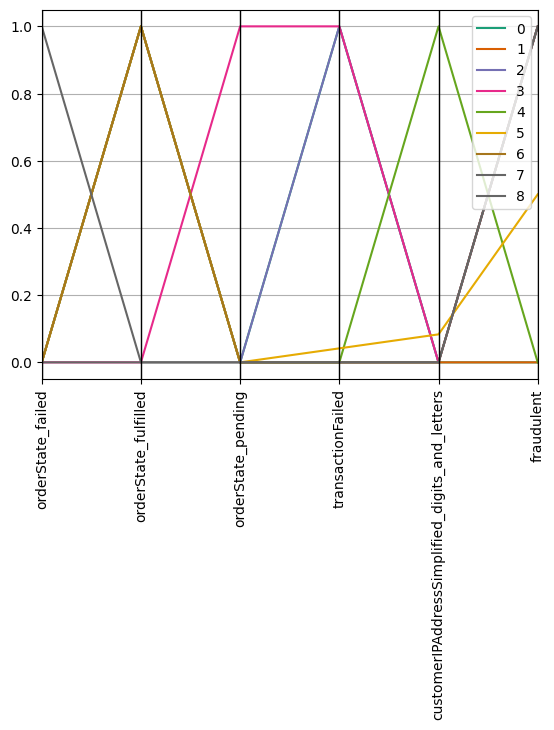

In [33]:
from funpymodeling.model_validation import coord_plot

d_orig, d_transf = coord_plot(x_data_cl, cluster_var)


INSIGHTS (del HDBSCAN):

1) Los clusters con mas casos (6 y 8), dan WARNING, y no tienen Order State Pending, ni Transaction Failed, y el IP ADDRESS es simple, solo de números.
2) Para el CLuester 5, da fraudulenta y resulta que no tiene Failed Transaction ni Order State Pending, casi todos las IP ADDRESS son sólo de números.
3) Para el Cluster 4, las IP ADDRESS son de números y letras, y a su vez no tiene Failed Transactions.
